In [1]:
%load_ext autoreload
%autoreload 2
#%env CUDA_VISIBLE_DEVICES=3

#### Download packages if in Google Colab

In [2]:
colab_requirements = [
    "pip install tensorflow-gpu==2.0.0-beta0",
    "pip install librosa",
    "pip install noisereduce",
    "pip install soundfile",

]

import sys, subprocess

def run_subprocess_command(cmd):
    # run the command
    process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE)
    # print the output
    for line in process.stdout:
        print(line.decode().strip())

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    for i in colab_requirements:
        run_subprocess_command(i)

Created wheel for noisereduce: filename=noisereduce-1.1.0-cp37-none-any.whl size=7610 sha256=00ab5e8482186bfa5dc2aefa716f7190f34c8e500835ddd4f231abc088d6e89a
Stored in directory: /root/.cache/pip/wheels/a6/2c/70/f9ccb41280dcfbe3eaeb7930f913dd85394617f3d3136f29cc
Successfully built noisereduce


# Test noise reduction algorithm and view steps of algorithm

In [3]:
import IPython
from scipy.io import wavfile
import noisereduce as nr
import soundfile as sf
from noisereduce.generate_noise import band_limited_noise
import matplotlib.pyplot as plt
import urllib.request
import numpy as np
import io
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/noisereduce/noisereduce.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


### Load data

In [4]:
url = "https://raw.githubusercontent.com/timsainb/noisereduce/master/assets/fish.wav"
response = urllib.request.urlopen(url)
data, rate = sf.read(io.BytesIO(response.read()))
data = data

In [6]:
IPython.display.Audio(data=data, rate=rate)

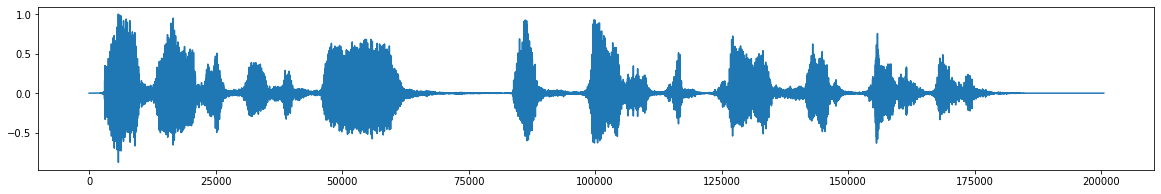

In [7]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(data)

### add noise

In [8]:
noise_len = 2 # seconds
noise = band_limited_noise(min_freq=2000, max_freq = 12000, samples=len(data), samplerate=rate)*10
noise_clip = noise[:rate*noise_len]
audio_clip_band_limited = data+noise

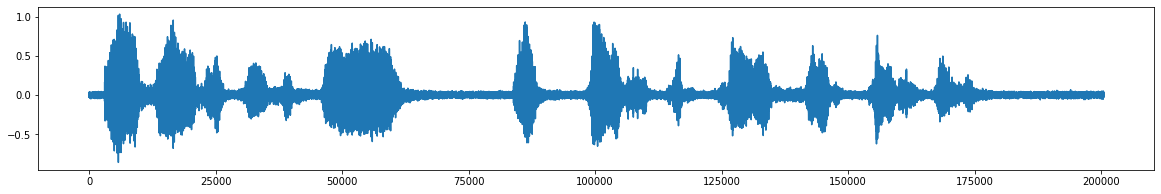

In [9]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(audio_clip_band_limited)

In [10]:
IPython.display.Audio(data=audio_clip_band_limited, rate=rate)

### remove noise

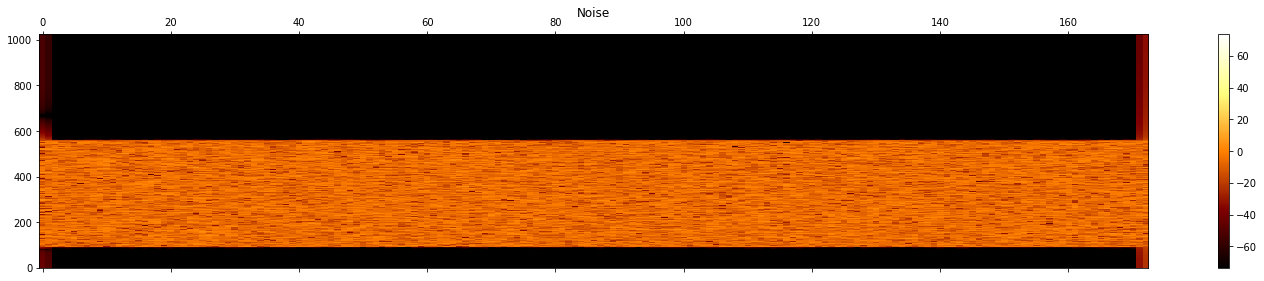

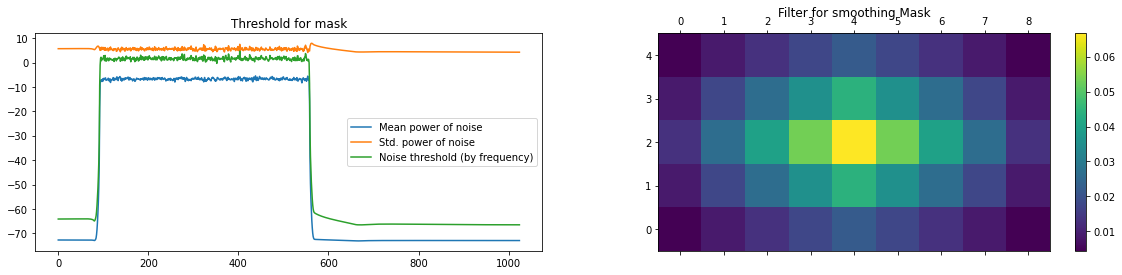

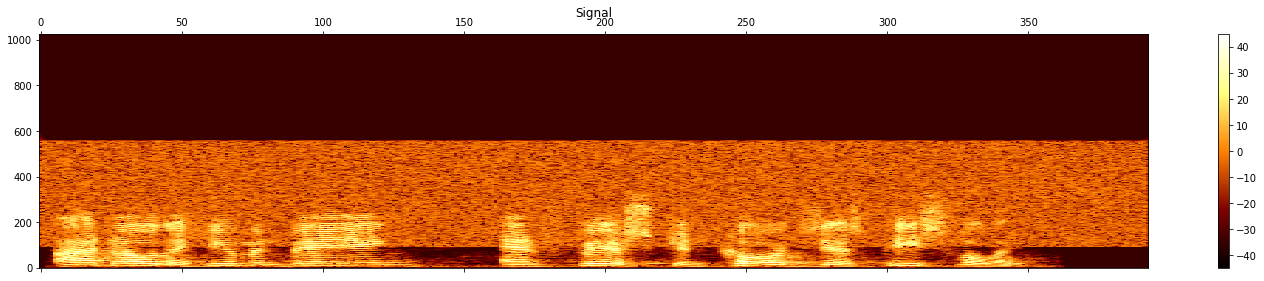

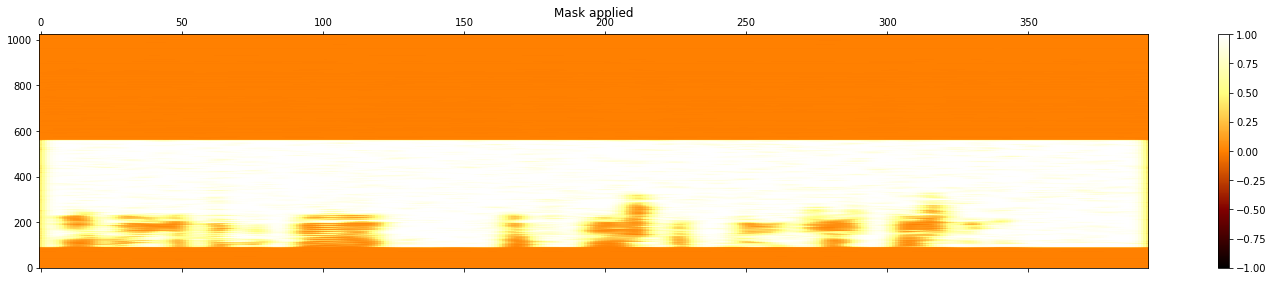

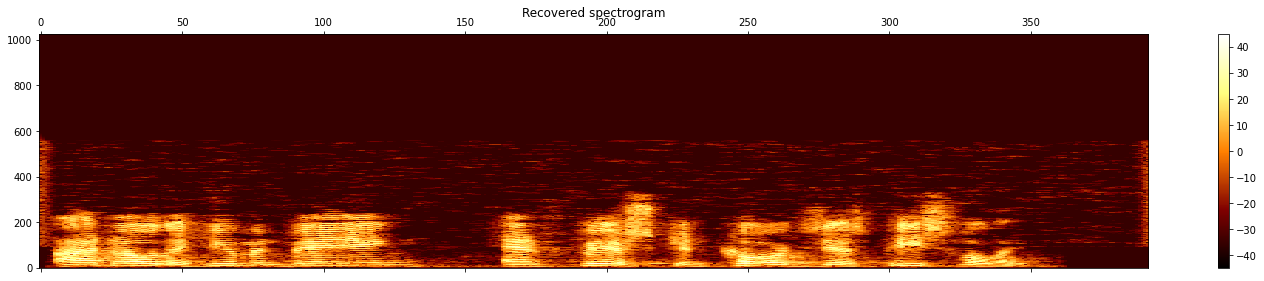

In [11]:
noise_reduced = nr.reduce_noise(audio_clip=audio_clip_band_limited, noise_clip=noise_clip, prop_decrease=1.0, verbose=True)

##### playback recovered audio

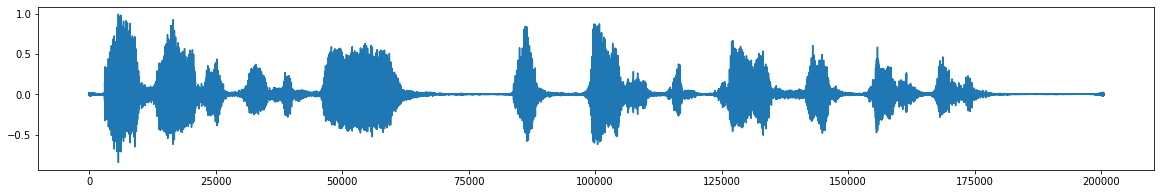

In [12]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(noise_reduced)

In [13]:
IPython.display.Audio(data=noise_reduced, rate=rate)

## A more difficult example 

In [14]:
url = "https://raw.githubusercontent.com/timsainb/noisereduce/master/assets/cafe_short.wav"
response = urllib.request.urlopen(url)
noise_data, noise_rate = sf.read(io.BytesIO(response.read()))

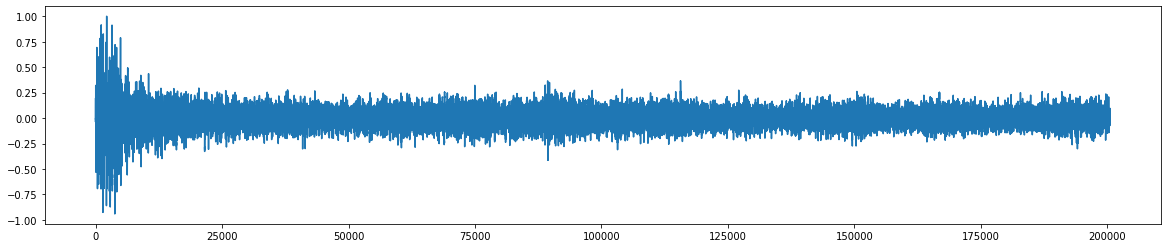

In [15]:
fig, ax = plt.subplots(figsize=(20,4))
ax.plot(noise_data)

In [16]:
IPython.display.Audio(data=noise_data, rate=noise_rate)

In [17]:
max(noise_data)

0.999969482421875

### add noise to data

In [18]:
snr = 2 # signal to noise ratio
noise_clip = noise_data/snr
audio_clip_cafe = data + noise_clip

### plot noisy data

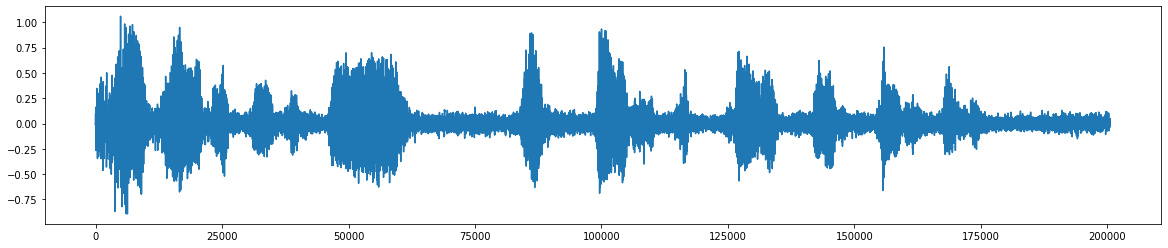

In [19]:
fig, ax = plt.subplots(figsize=(20,4))
ax.plot(audio_clip_cafe)

IPython.display.Audio(data=audio_clip_cafe, rate=noise_rate)

### reduce noise

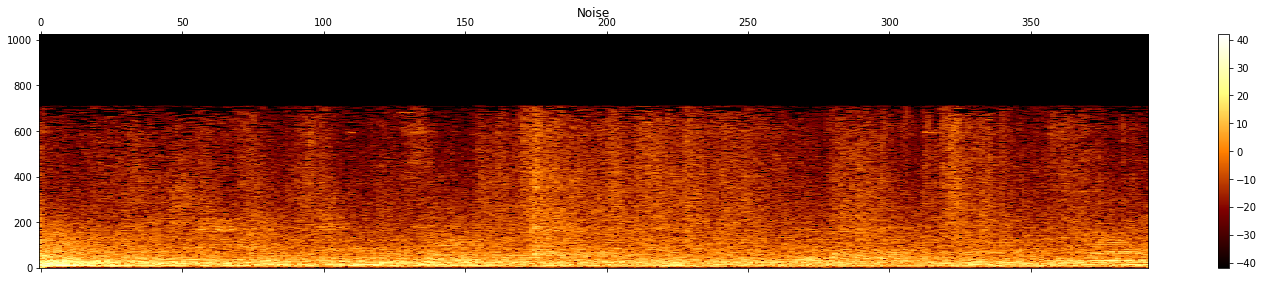

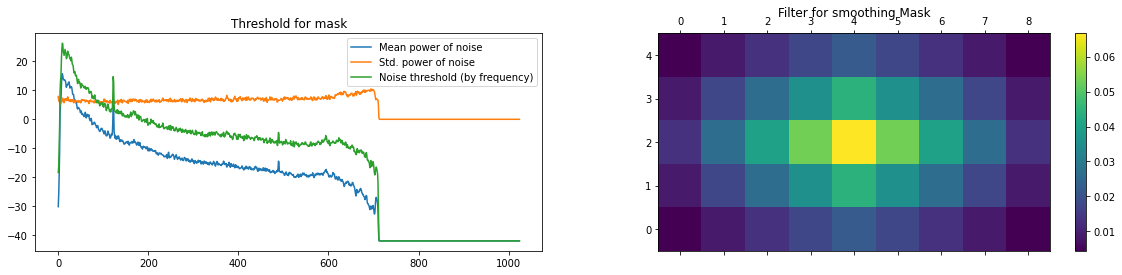

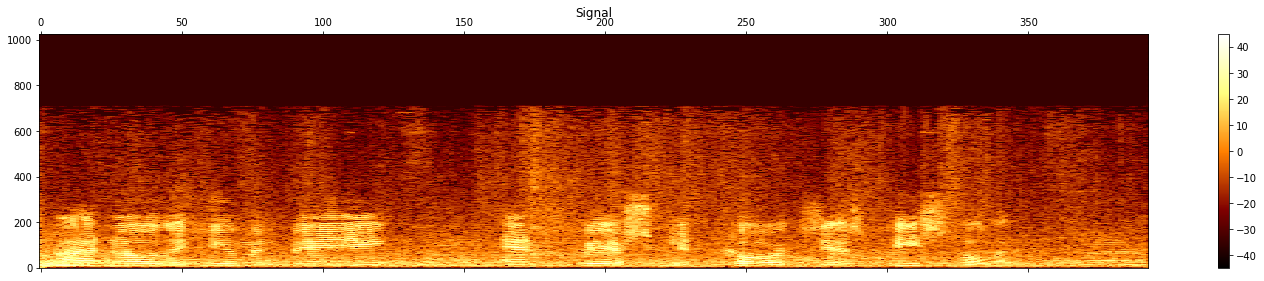

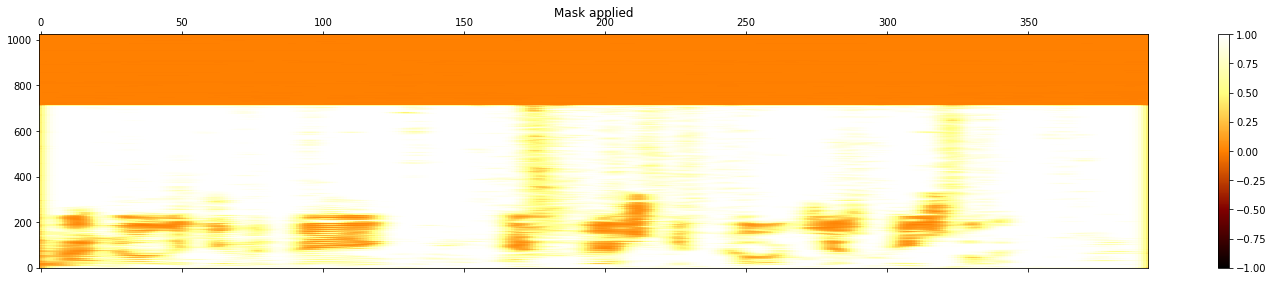

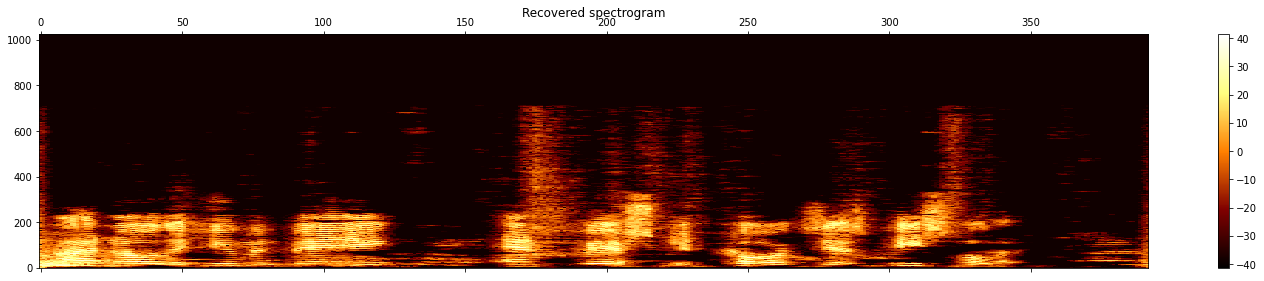

In [20]:
noise_reduced = nr.reduce_noise(audio_clip=audio_clip_cafe, noise_clip=noise_clip, verbose=True)

##### playback recovered audio

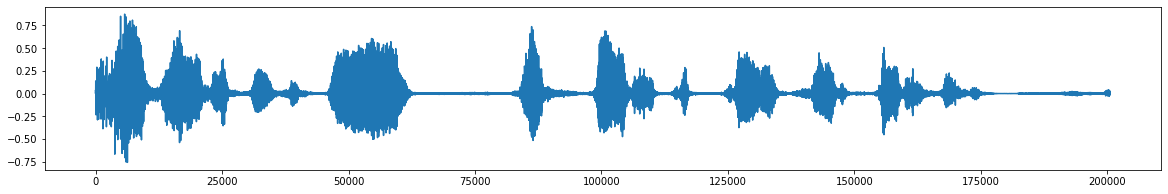

In [21]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(noise_reduced)

In [22]:
IPython.display.Audio(data=noise_reduced, rate=rate)

## Use tensorflow as the backend for noise reduction

In [23]:
noise_reduced = nr.reduce_noise(audio_clip=audio_clip_cafe.astype('float32'),
                                noise_clip=noise_clip.astype('float32'),
                                use_tensorflow=True, 
                                verbose=False)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [24]:
len(noise_reduced), len(audio_clip_cafe)

(200542, 200542)

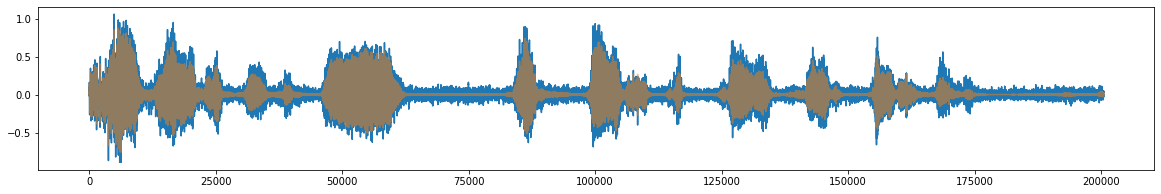

In [25]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(audio_clip_cafe)
ax.plot(noise_reduced, alpha = 0.5)

In [26]:
IPython.display.Audio(data=noise_reduced, rate=rate)

### Compare times

In [27]:
%%timeit
# non-tensorflow
noise_reduced = nr.reduce_noise(audio_clip=audio_clip_cafe.astype('float32'),
                                noise_clip=noise_clip.astype('float32'),
                                use_tensorflow=False, 
                                verbose=False)

10 loops, best of 5: 130 ms per loop


In [28]:
%%timeit
# Use tensorflow
noise_reduced = nr.reduce_noise(audio_clip=audio_clip_cafe.astype('float32'),
                                noise_clip=noise_clip.astype('float32'),
                                use_tensorflow=True, 
                                verbose=False)

/usr/local/lib/python3.7/dist-packages/noisereduce/noisereduce.py:162: UserWarning: Tensorflow is not installed, reverting to non-tensorflow backend
  "Tensorflow is not installed, reverting to non-tensorflow backend"


10 loops, best of 5: 134 ms per loop


#### compare longer clips

In [29]:
# make a longer clip by repeating the same clip a few times
longer_clip = np.concatenate([audio_clip_cafe.astype('float32') for i in range(100)])
print("Clip is {} seconds long.".format(round(len(longer_clip)/rate)))

Clip is 455 seconds long.


In [30]:
%%time
# non-tensorflow
noise_reduced = nr.reduce_noise(audio_clip=longer_clip,
                                noise_clip=noise_clip.astype('float32'),
                                use_tensorflow=False, 
                                verbose=False)

CPU times: user 12.2 s, sys: 915 ms, total: 13.1 s
Wall time: 13 s


In [31]:
%%time
# use tensorflow
noise_reduced = nr.reduce_noise(audio_clip=longer_clip,
                                noise_clip=noise_clip.astype('float32'),
                                use_tensorflow=True, 
                                verbose=False)

/usr/local/lib/python3.7/dist-packages/noisereduce/noisereduce.py:162: UserWarning: Tensorflow is not installed, reverting to non-tensorflow backend
  "Tensorflow is not installed, reverting to non-tensorflow backend"


CPU times: user 12.3 s, sys: 131 ms, total: 12.4 s
Wall time: 12.4 s


### ensure that noise reduction does not cause distortion when prop_decrease == 0

In [32]:
noise_reduced = nr.reduce_noise(audio_clip=data, noise_clip=noise_clip, prop_decrease=0, verbose=False)

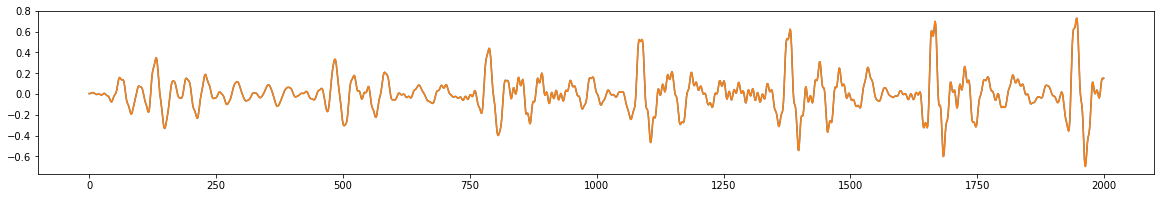

In [33]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(noise_reduced[3000:5000])
ax.plot(data[3000:5000])